In [1]:
import sympy as sp
import opt_einsum as oe

from sympy import I
sp.init_printing()

In [2]:
dim = 4
g = sp.Matrix.diag([1, -1, -1, -1])
# g = np.diag([1, -1, -1, -1])  # The minkowski metric

# Pauli matrices
s = []
s.append(sp.Matrix([
    [0, 1],
    [1, 0]
]))
s.append(sp.Matrix([
    [0, -I],
    [I, 0]
]))
s.append(sp.Matrix([
    [1, 0],
    [0, -1]
]))

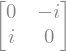

In [3]:
s[1]

In [4]:
# Dirac matricies

Oh = sp.Matrix([[0, 0],[0, 0]])
eye = sp.eye(2)

γ = []
γ.append(sp.Matrix([
    [eye, Oh],
    [Oh, -eye]
]))

for i in range(3):
    γ.append(sp.Matrix([
        [Oh, s[i]],
        [-s[i], Oh]
    ]))

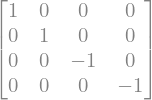

In [5]:
γ[0]

In [6]:
γ5 = I * (γ[0] * γ[1] * γ[2] * γ[3])

In [7]:
γ5_γ = [γ5 * γ[i] for i in range(dim)]
γ_γ5 = [γ[i] * γ5 for i in range(dim)]

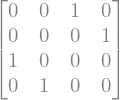

In [8]:
γ5

In [12]:
# Returns the adjoint spinor
def adj(u):
    return Dagger(u) @ γ[0]

def slash(a):
    slasha = 0 * γ[0]
    for i in range(dim):
        slasha += γ[i] * a[i]
    return slasha

def contract_tensor_vectors(T, p):
    """ Contracts tensor with list of vectors recursivley """
    if len(p)==0: return T
    return contract_tensor_vector(sum([T[i, ...] * p[0][i] for i in range(dim)]), p[1::])

import numpy as np

def Tr(γ_list):
    """ Returns TR[γ_list[0] γ_list[1] ...] """
    # Einsum does not accept sp.Rational :(
    indcs = "abcdefghijklmn" # just in case
    nr_indx = len(γ_list)
    shape = [dim] * nr_indx + [dim, dim]
    A = np.full(shape, γ_list[0])

    for i, γ in enumerate(γ_list[1::]):
        s_indx = indcs[:len(γ_list)] + "xy, "
        s_indx += indcs[len(γ_list) - 2 - i] + "yz -> "
        s_indx += indcs[:len(γ_list)] + "xz"
        A = oe.contract(s_indx, A, γ, backend='object')

    return sp.Array(oe.contract("...ii", A, backend='object'))


def INDX(i, place, num_indx):
    """
    Acceses an index at 'place' for 'num_indx' order tensor
    T_(a0 ... âp ... an-1) = T[INDX(i, place=p, num_indx=n)] = T[:,...<-p-> , i, :,...<-(n-p-1)->]
    """
    indx = []
    assert place<num_indx
    for j in range(num_indx):
        if place==j: indx.append(i)
        else: indx.append(slice(None))
    return tuple(indx)

In [55]:
from sympy import tensorproduct as tp
from sympy import tensorcontraction as tc

def prod(A, v):
    return tc(tp(A, v), (1, 2))


def dot(v1, v2):
    return tc(tp(v1, v2), (0, 1))

num_vec = 4
p_u = sp.Array([
    sp.symbols("p^{(" + str(j) + ")}_" + str(i)) for j in range(num_vec) 
    for i in range(dim)
]).reshape(num_vec, dim)

p_d = sp.Array([prod(g, p_u[i]) for i in range(num_vec)])

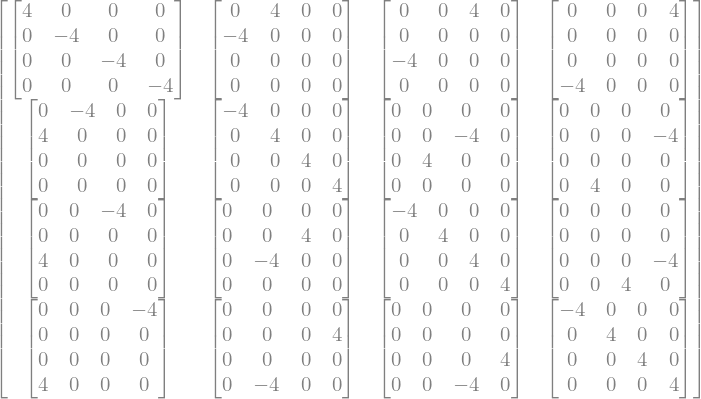

In [43]:
def sum(lst):
    s = lst[0]
    for l in lst[0:]:
        s += l
    return s

l = (γ, γ, γ, γ)
t1 = Tr(l)
t1

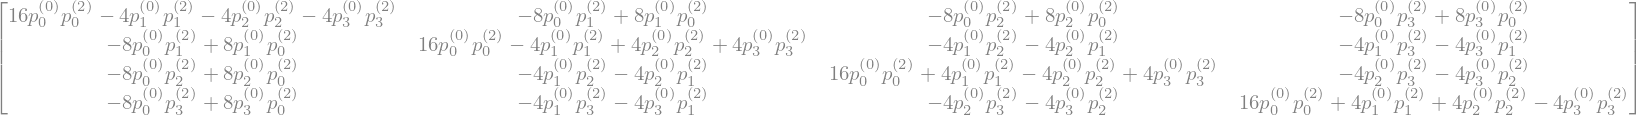

In [46]:
t1 = sum([t1[:,i] * p_d[0, i] for i in range(dim)])
t1 = sum([t1[:, :, i] * p_u[2, i] for i in range(dim)])
t1

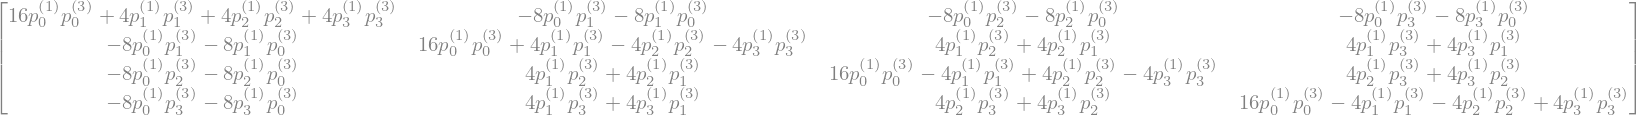

In [47]:
t2 = Tr(l)

t2 = sum([t2[:, i] * p_u[1, i] for i in range(dim)])
t2 = sum([t2[:, :, i] * p_u[3, i] for i in range(dim)])

t2_d = prod(g, prod(g, t2))

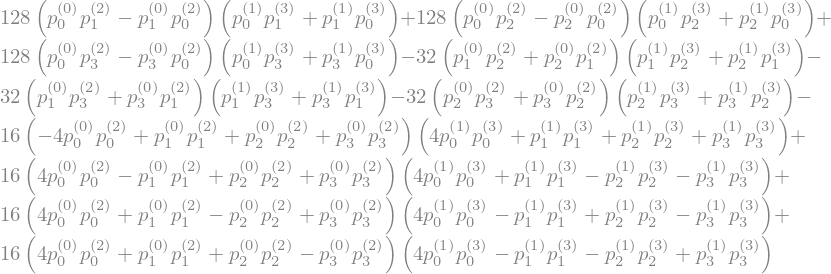

In [49]:
res = tc(tc(tp(t1, t2), (1, 2)), (0, 1))
sp.simplify(res)

In [59]:
sol = dot(p_u[0], p_d[1]) * dot(p_u[2], p_d[3]) + dot(p_u[0], p_d[3]) * dot(p_u[1], p_d[2])

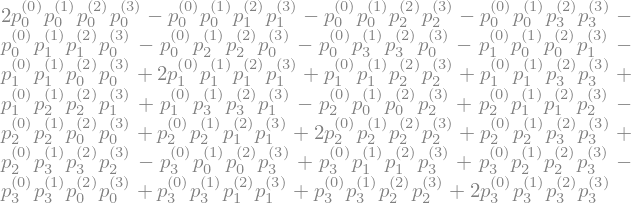

In [62]:
sp.expand(sol)

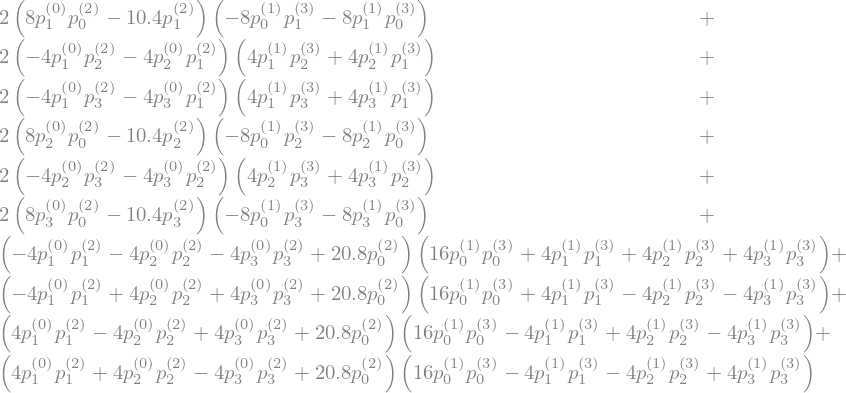

In [70]:
p1 = []

res.subs(p_u[0, 0], 1.3)